# Hesitation analysis nb
Nb for testing out somr functions and other stuff for hesitation analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pythonlib.tools.stroketools import *
from drawmonkey.tools.utils import *
from drawmonkey.tools.preprocess import *
from pyvm.classes.videoclass import Videos
from pythonlib.tools.expttools import load_yaml_config
from pyvm.globals import BASEDIR
from drawmonkey.tools.handtrack import HandTrack, getTrialsCameraFrametimes
from pyvm.utils.directories import get_metadata
import matplotlib.pyplot as plt
from pythonlib.drawmodel.strokePlots import *
import pythonlib
from pythonlib.dataset.dataset import load_dataset_notdaily_helper, load_dataset_daily_helper
from pythonlib.dataset.dataset_strokes import preprocess_dataset_to_datstrokes
import pickle

In [4]:
def flip_save_dict_keys(dict_in):
	#Quick funciton to make df keys better instead of just generating it better
	new_df = {}
	for trial, coefs_dict in dict_in.items():
		for coefs,dat in coefs_dict.items():
			if coefs not in new_df.keys():
				new_df[coefs] = {}
			new_df[coefs][trial] = dat
	return new_df

In [5]:
#Add data here as needed
decide_data_dict = {
    'diego1': ('Diego','230913_dirgrammardiego5d'),
    'diego2': ('Diego','231118_gramdiego1b'),
    'pancho1': ('Pancho','231114_grampancho1')
}

#Change key here ot chaneg what data being used in the plotting
key_to_use = 'diego1'

animal = decide_data_dict[key_to_use][0]
name = decide_data_dict[key_to_use][1]
#Only work if 1 session
date = name.split('_')[0]
expt = name.split('_')[1]

In [7]:
dat_dir = f'/home/danhan/freiwaldDrive/dhanuska/hand_track/{animal}/{name}/processed_data.pkl'
with open(dat_dir,'rb') as f:
    dat_load = pickle.load(f)
#Only work if one session
fd = loadSingleDataQuick(animal,date,expt,1)

-- loaded presaved data: /home/danhan/freiwaldDrive/kgupta/macaque_data/Diego/230913/230913_153155_dirgrammardiego5d_Diego_1.pkl


In [9]:
dat_trials = dat_load['220914_f12_dlc']

In [10]:
gaps = []
for trial,d in dat_trials.items():
    if len(d) != 0:
        for gap in d['trans_gaps_cam'][1:-1]:
            gaps.append(np.array(gap))


In [11]:
print(dat_trials[61].keys())

dict_keys(['strokes_cam', 'gaps_cam', 'pts_time_cam_all', 'strokes_touch', 'strokes_task', 'pnut_strokes', 'strokes_raw_times', 'reg_strokes_cam', 'reg_gaps_cam', 'reg_pts_time_cam_all', 'trans_strokes_cam', 'trans_gaps_cam', 'trans_pts_time_cam_all'])


In [12]:
print(len(dat_trials))

990


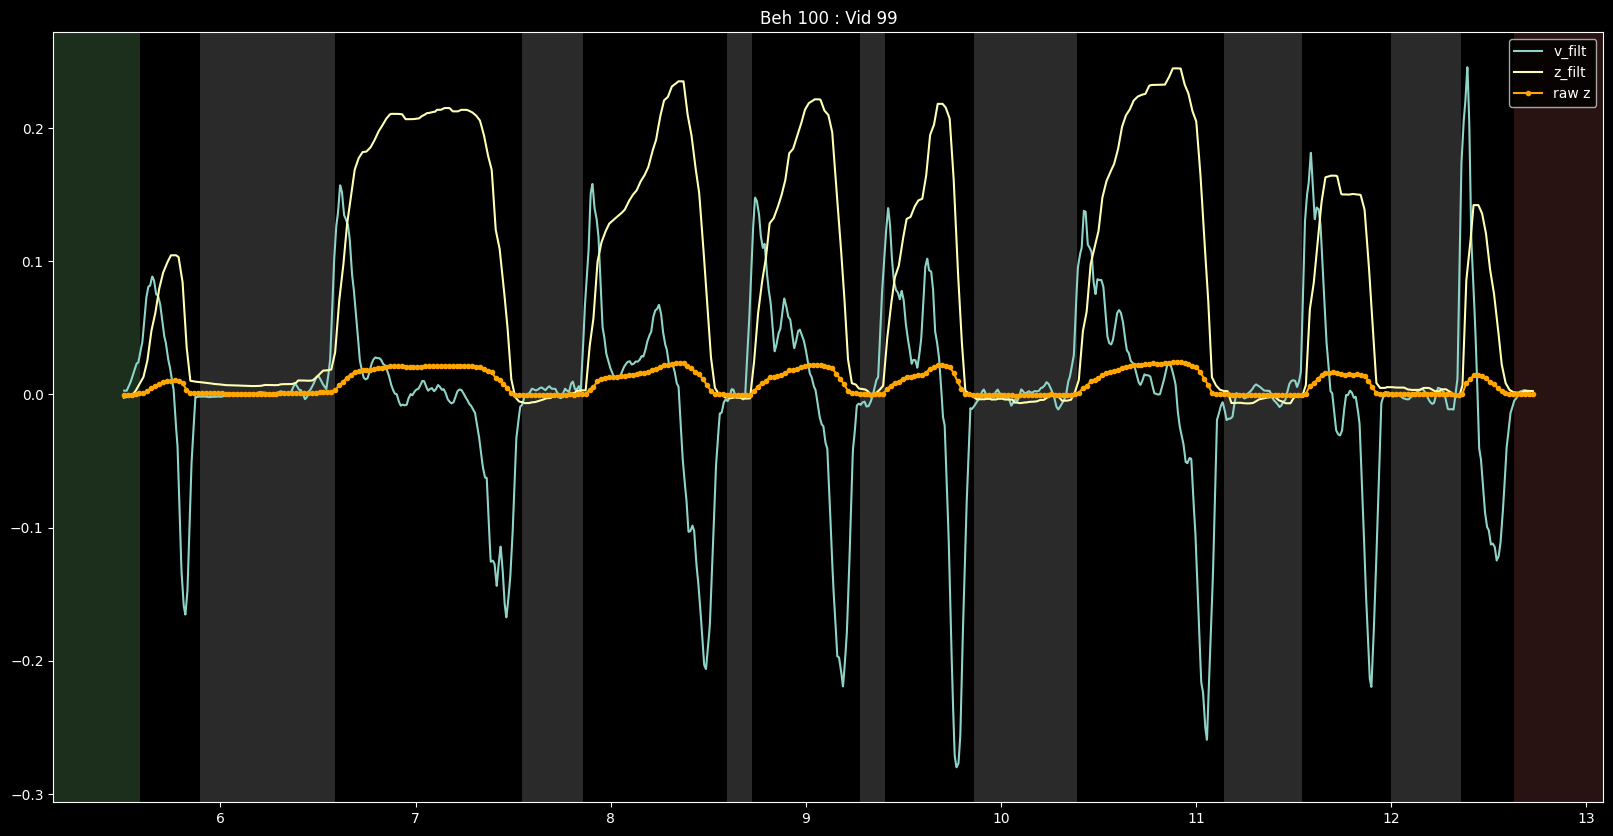

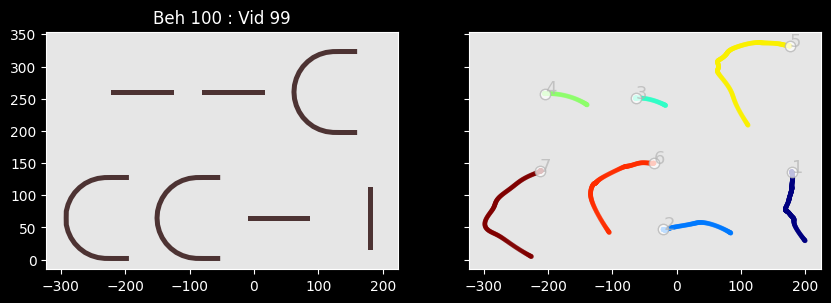

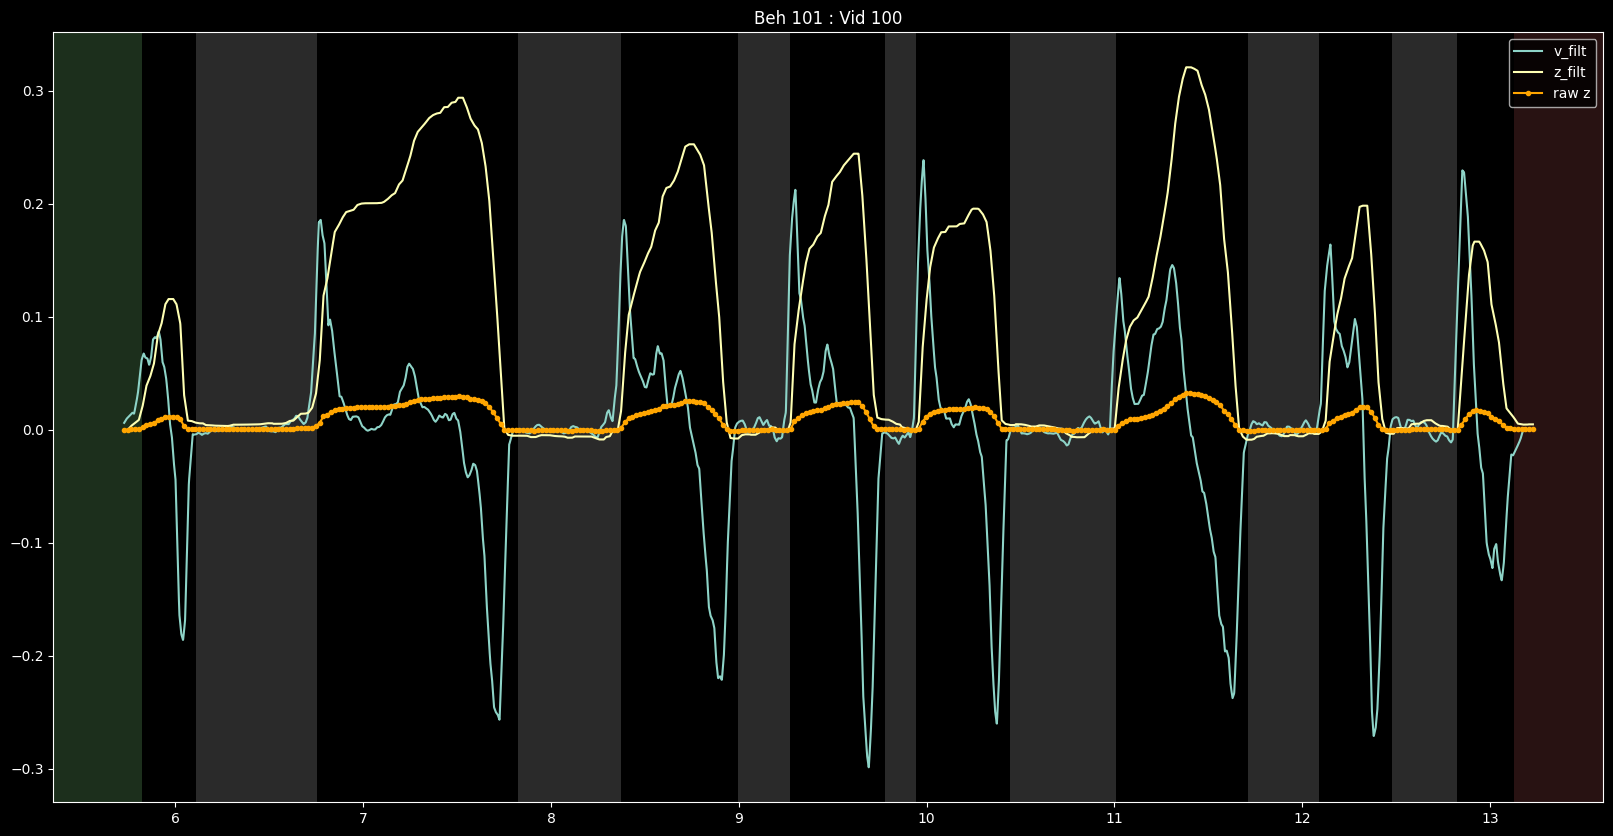

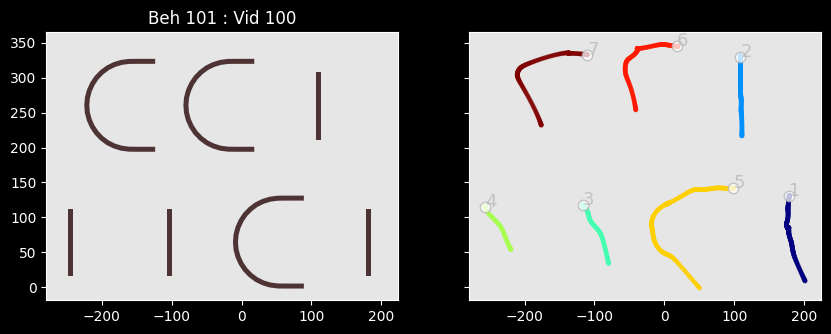

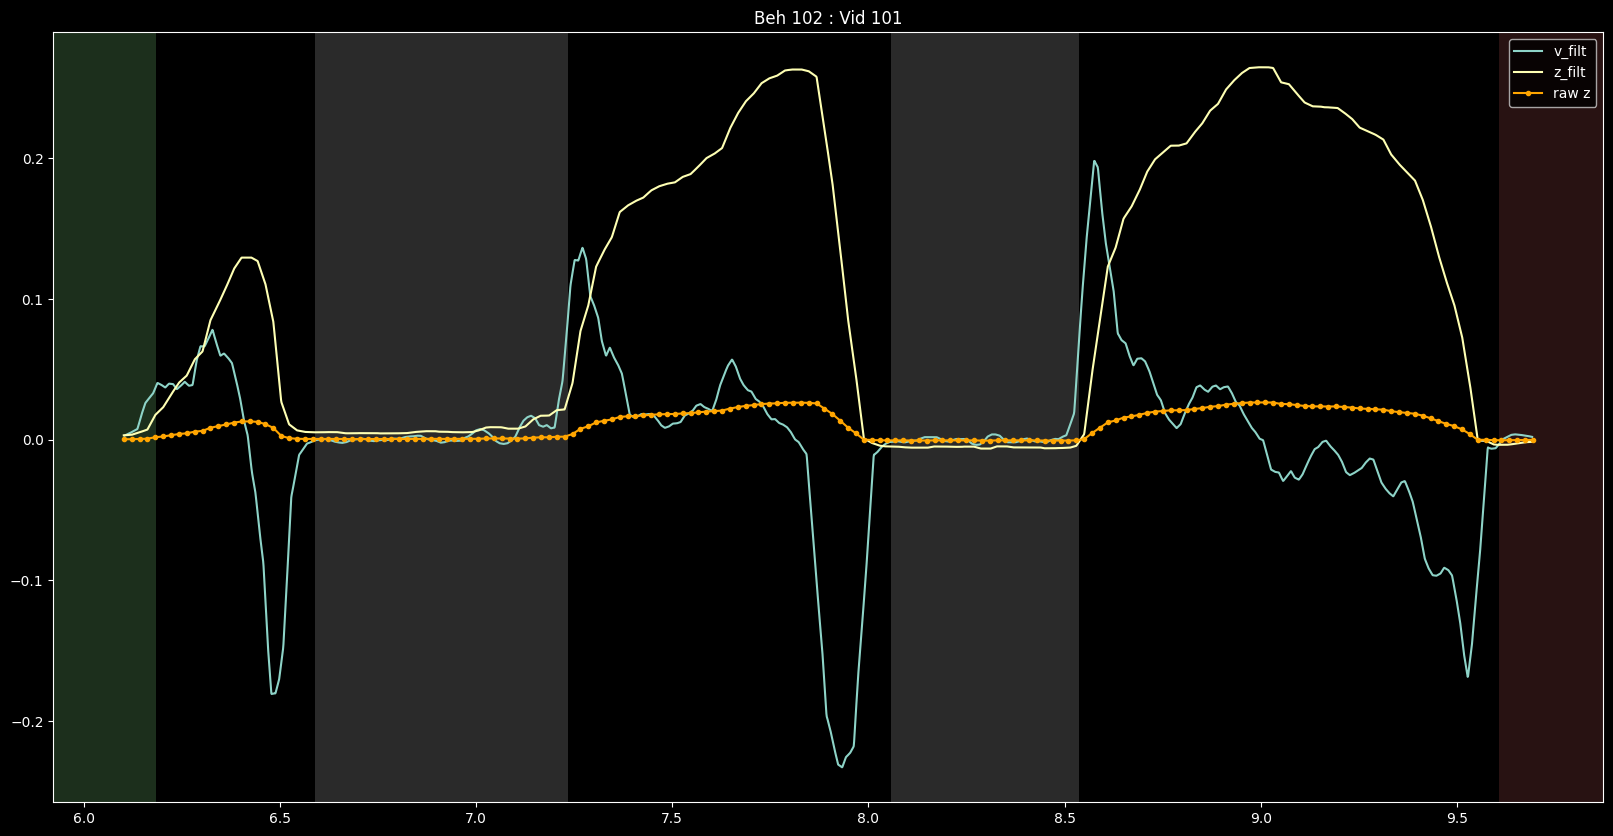

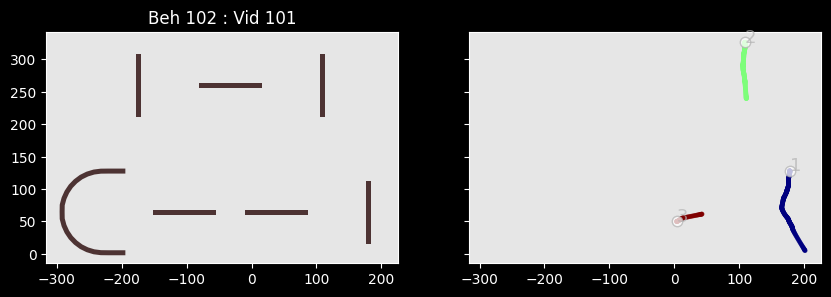

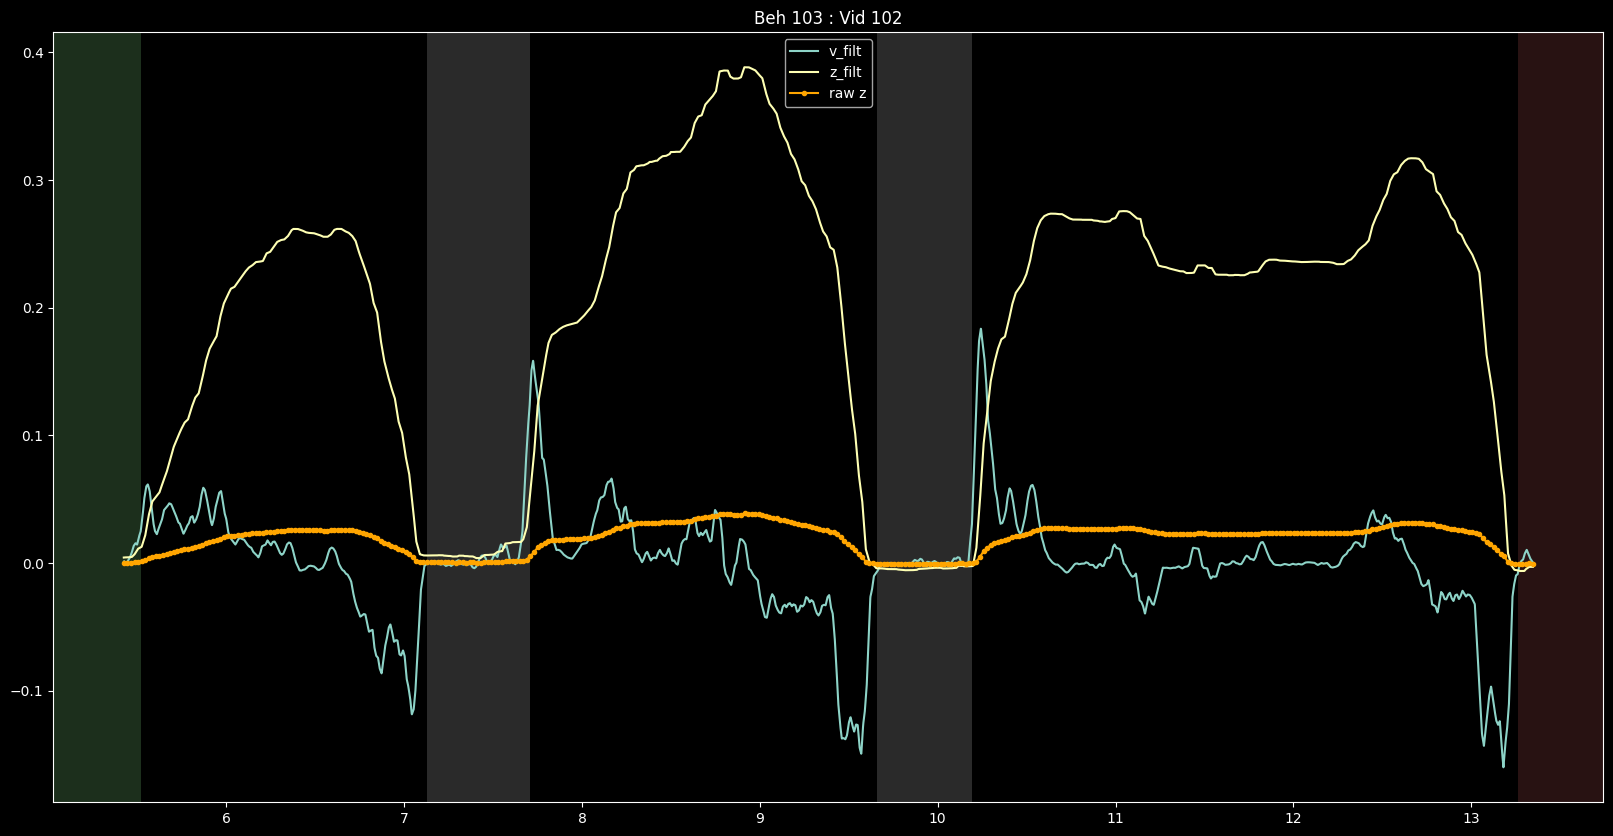

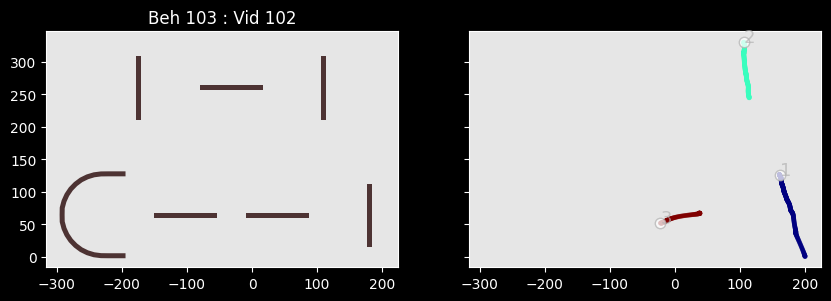

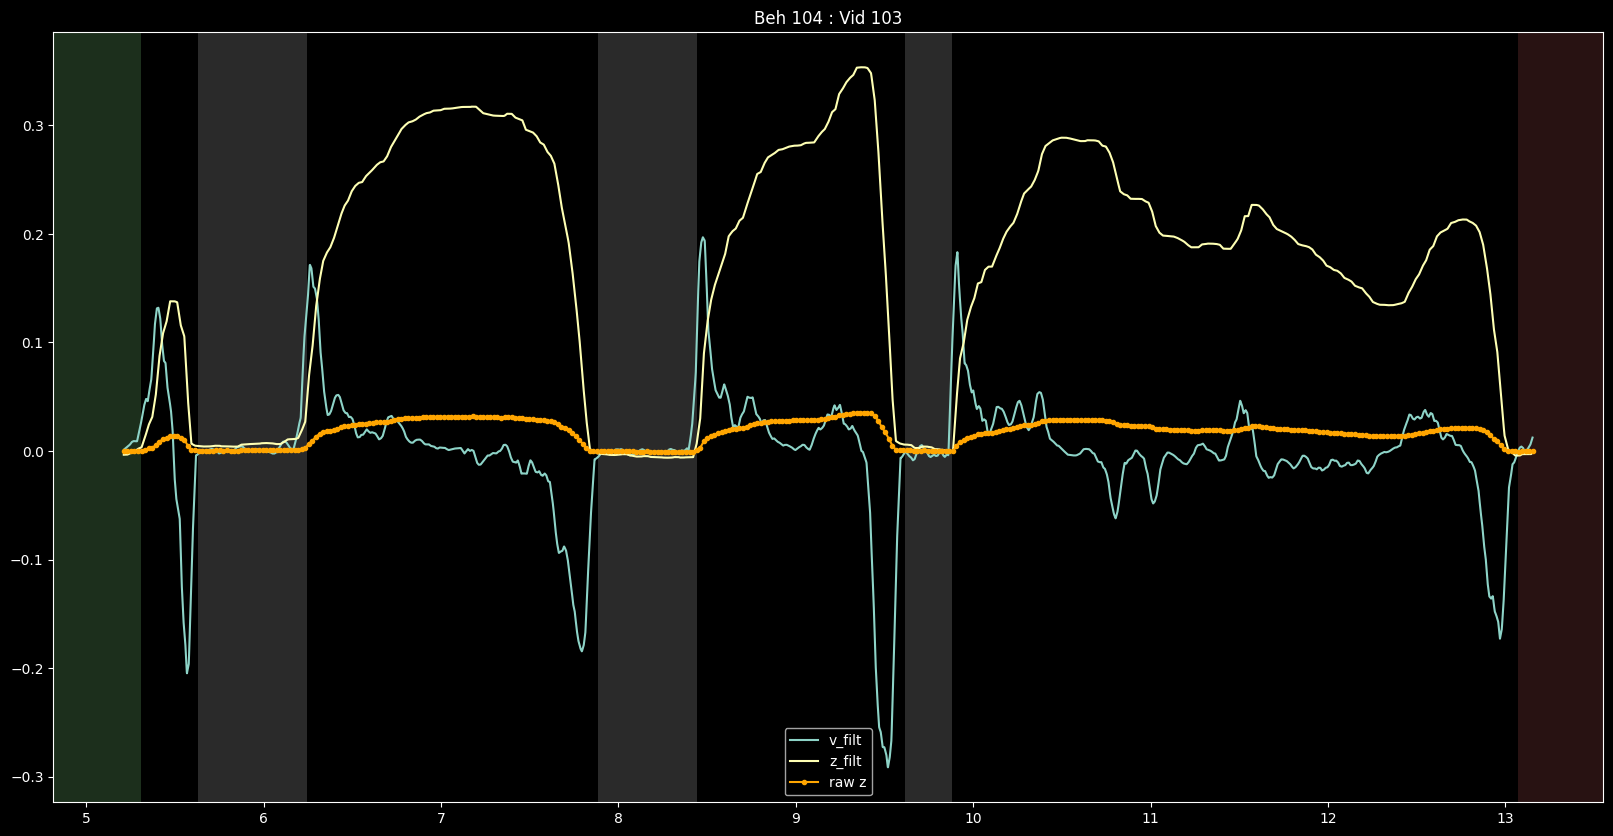

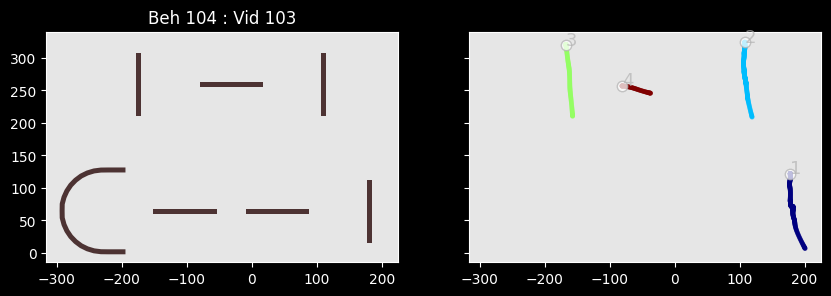

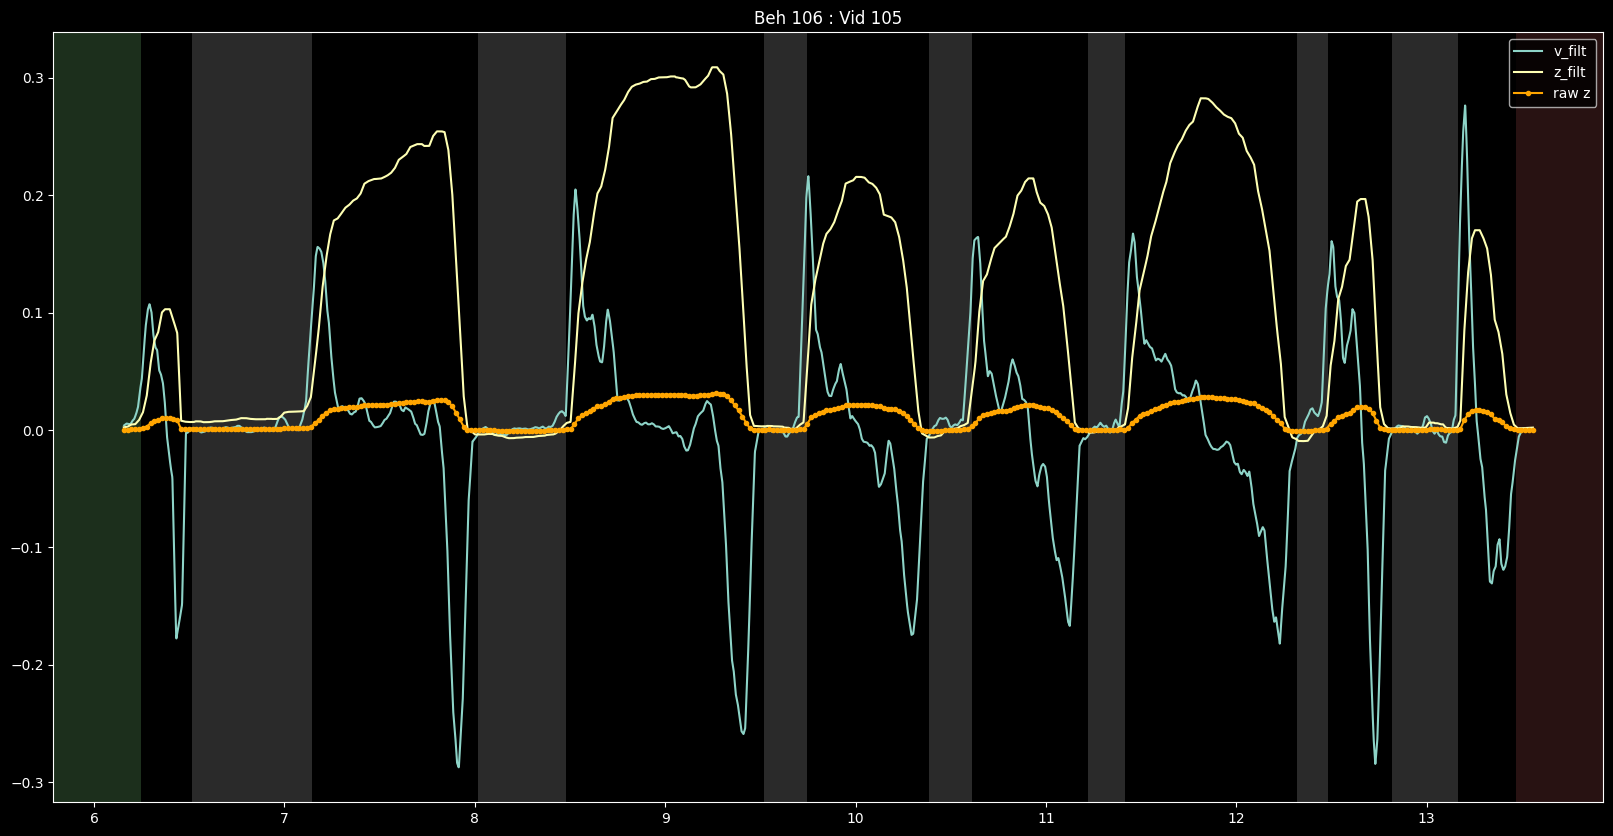

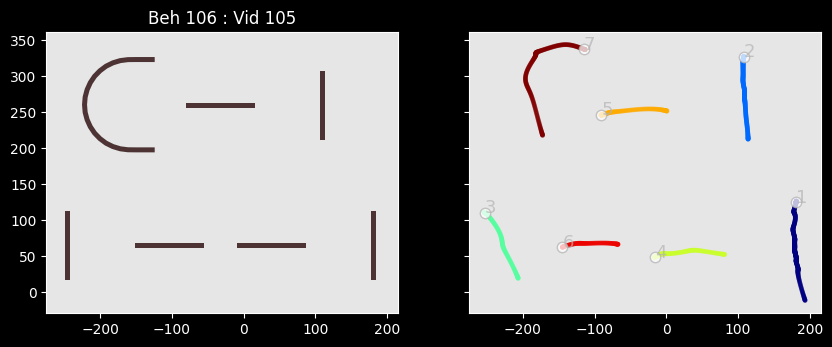

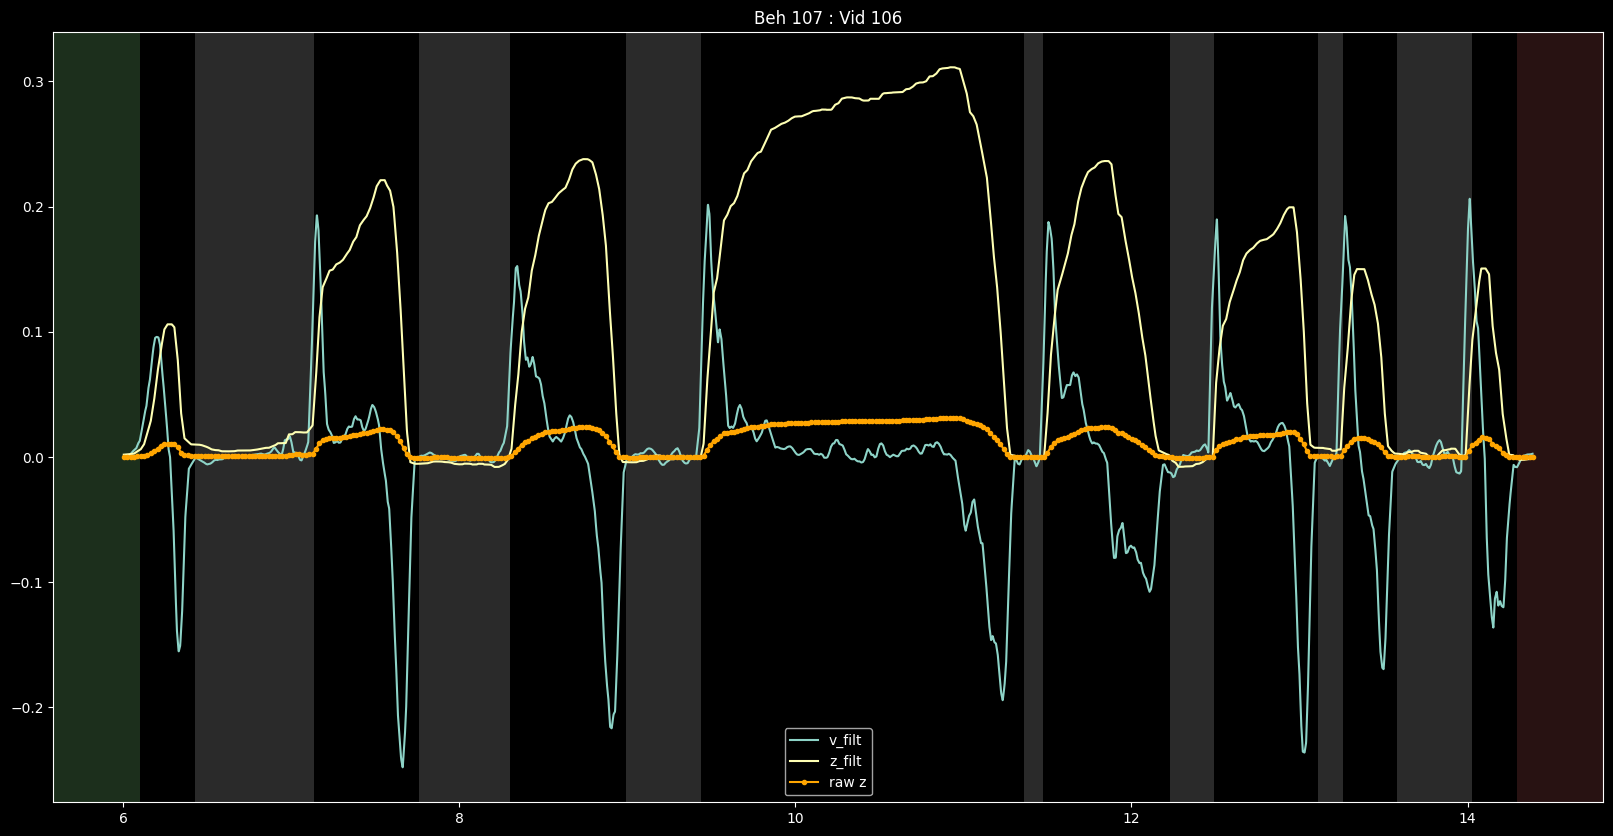

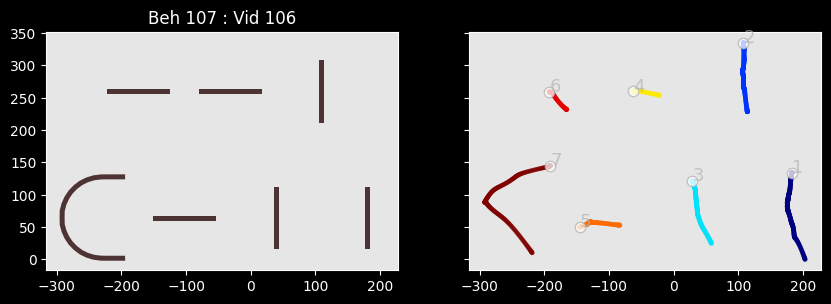

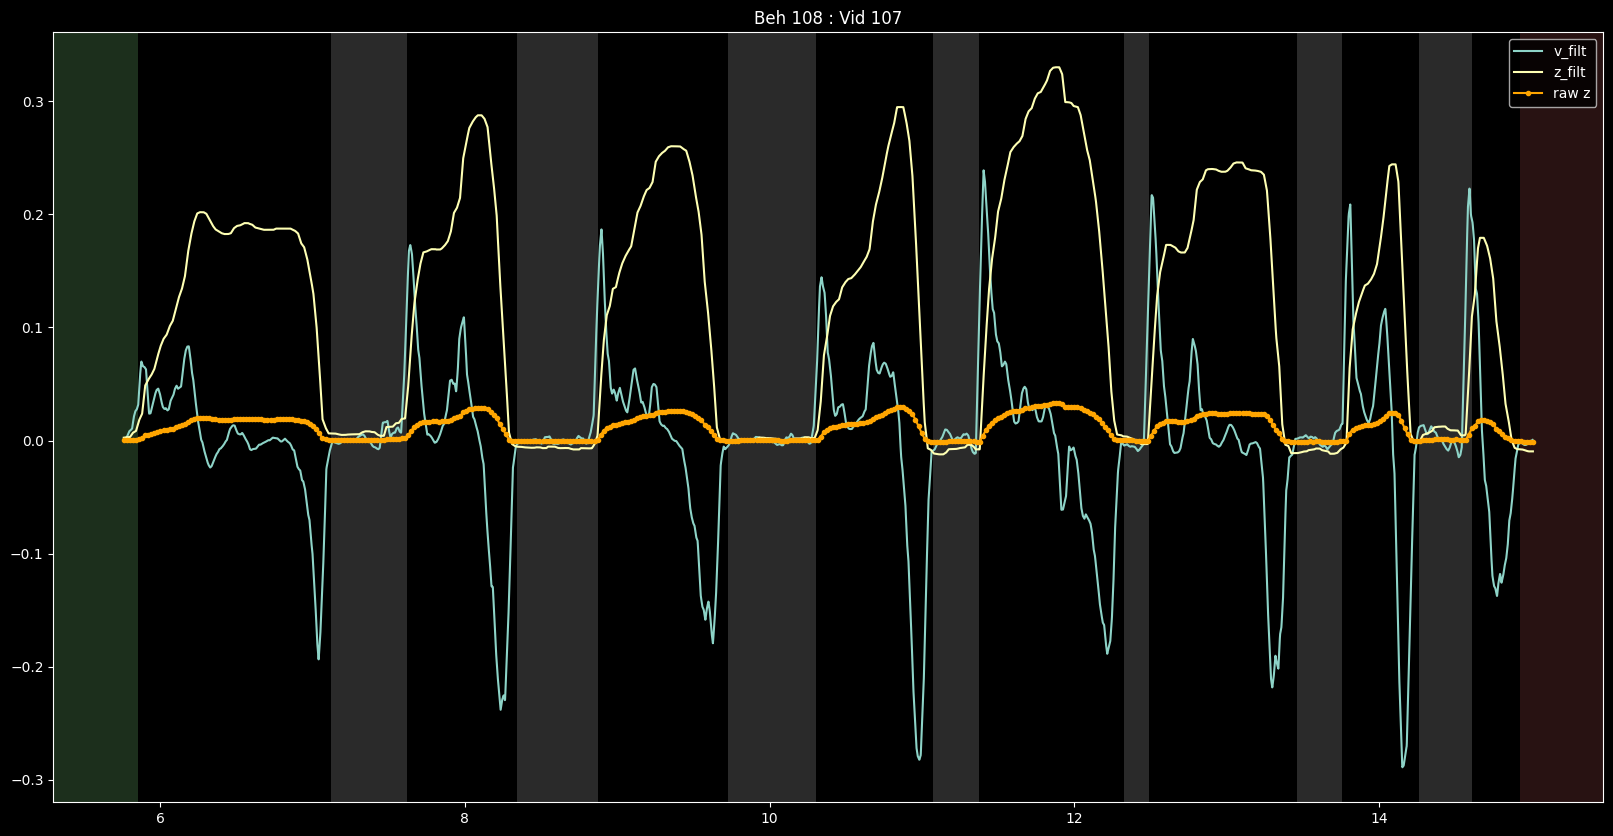

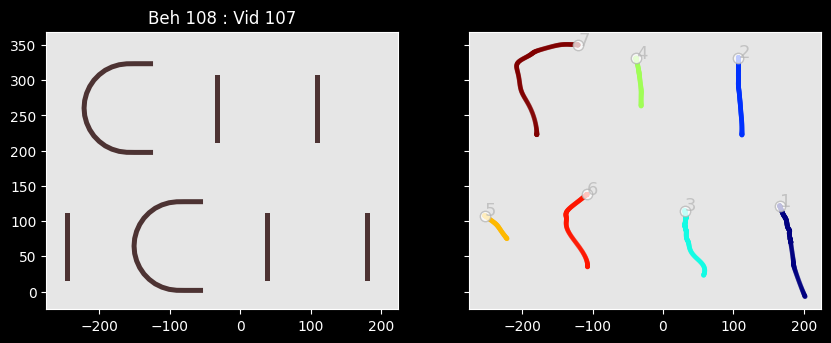

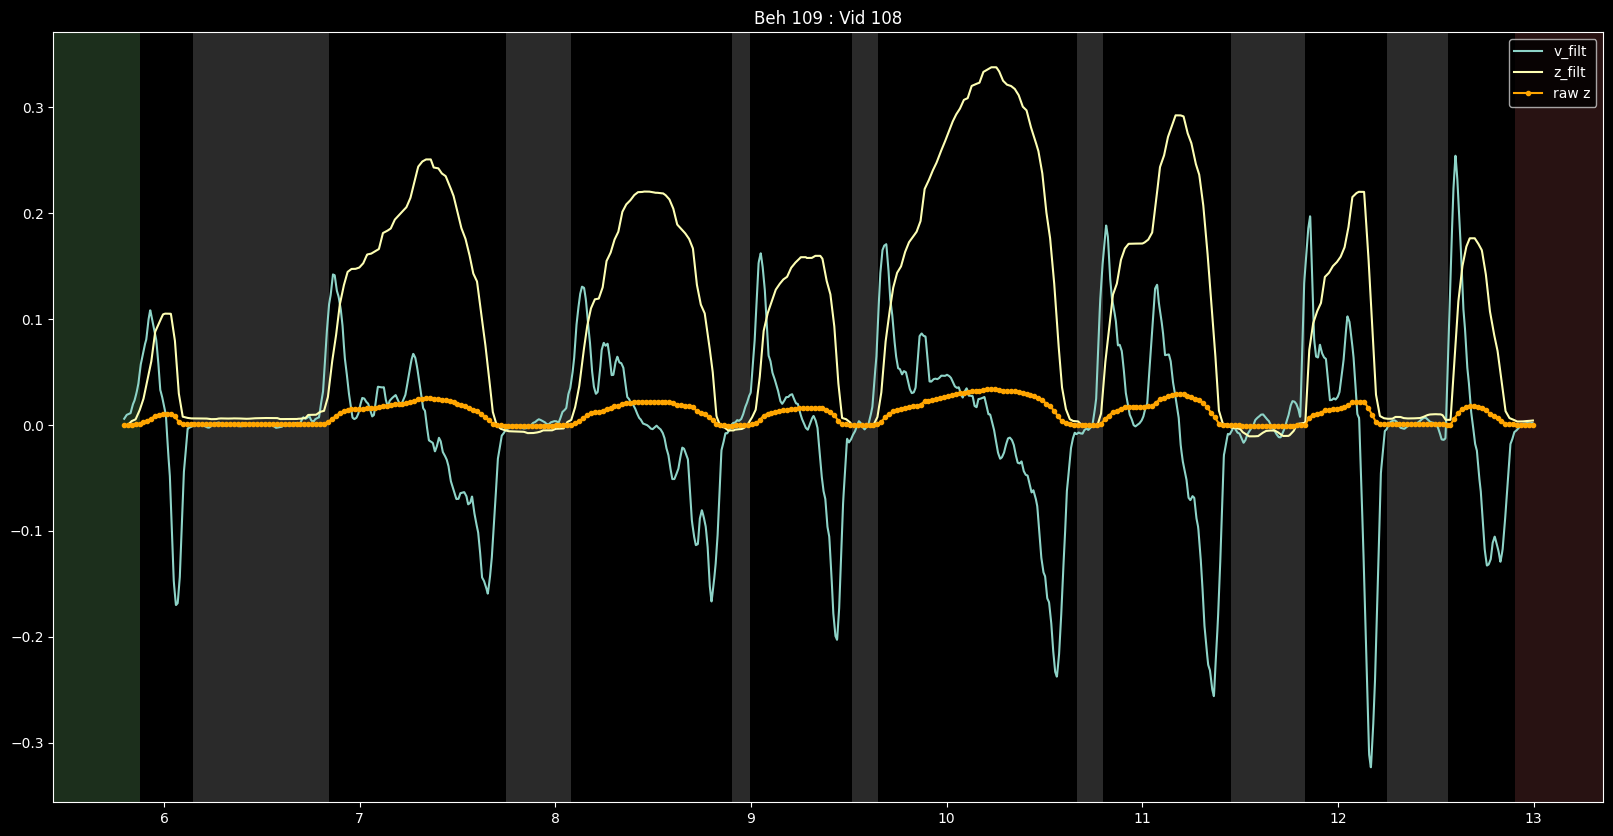

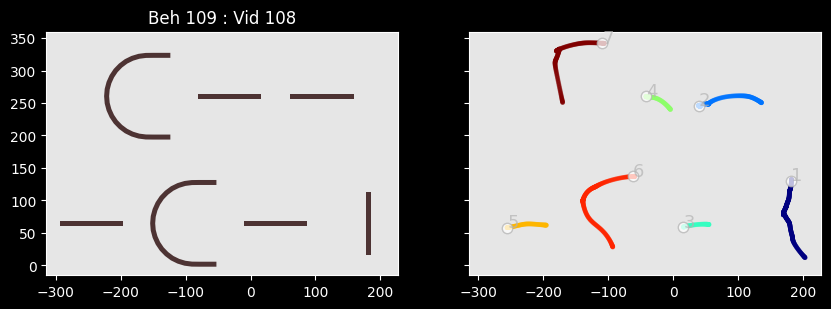

In [17]:
for trial,dat in dat_trials.items():
    strokes_task = getTrialsTaskAsStrokes(fd,trial)
    strokes_monkey = getTrialsStrokesByPeanuts(fd,trial)
    if len(dat) == 0:
        continue
    if trial in range(100,110):
        plotTrialsTrajectories(dat,trial)
        fig,ax = plt.subplots(1,2,figsize=[10,20],sharex=True,sharey=True)
        plotDatStrokes(strokes_task, ax[0], clean_task=True)
        plotDatStrokes(strokes_monkey,ax[1])
        ax[0].set_title(f'Beh {trial} : Vid {trial-1}')
        

        

In [42]:
# Load a daily dataset

animal = "Diego"
DATE = "230913"

D = load_dataset_daily_helper(animal, DATE)

Searching using this string:
/home/danhan/code/drawmonkey/drawmonkey/expt_metadat/*230913-*Diego.**
Found this many paths:
0
Searching using this string:
/home/danhan/code/drawmonkey/drawmonkey/expt_metadat_daily/*230913-*Diego.**
Found this many paths:
1
---
/home/danhan/code/drawmonkey/drawmonkey/expt_metadat_daily/dirgrammardiego5d-230913-Diego.yaml
Loading this dataset Diego dirgrammardiego5d 230913
Searching using this string:
/home/danhan/freiwaldDrive/dhanuska/analyses/database/*Diego-*dirgrammardiego5d-*230913-*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0
Searching using this string:
/home/danhan/freiwaldDrive/dhanuska/analyses/database/BEH/*Diego-*dirgrammardiego5d-*230913-*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0
Searching using this string:
/home/danhan/freiwaldDrive/kgupta/analyses/database/*Diego-*dirgrammardiego5d-*230913-*/*dat*.pkl
-- Splitting off dir from fname
Found this many paths:
0
Searching using this string:
/hom

/home/danhan/code/pythonlib/pythonlib/tools/pandastools.py:2583: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IGN' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column].isna(), column] = replace_with
/home/danhan/code/pythonlib/pythonlib/tools/pandastools.py:2583: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IGN' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column].isna(), column] = replace_with


Basis set of strokes: ['Lcentered-4-1-0', 'Lcentered-4-2-0', 'Lcentered-4-3-0', 'Lcentered-4-4-0', 'V-2-2-0', 'V-2-3-0', 'V-2-4-0', 'arcdeep-4-2-0', 'arcdeep-4-3-0', 'arcdeep-4-4-0', 'circle-6-1-0', 'line-8-1-0', 'line-8-2-0', 'line-8-3-0', 'line-8-4-0', 'squiggle3-3-1-0', 'squiggle3-3-1-1', 'squiggle3-3-2-0', 'squiggle3-3-2-1', 'usquare-1-2-0', 'usquare-1-3-0', 'usquare-1-4-0', 'zigzagSq-1-1-0', 'zigzagSq-1-1-1', 'zigzagSq-1-2-0', 'zigzagSq-1-2-1']
Deleting these columns with seqc in name: []
Appended columns gridsize!
SAVING at:  /home/danhan/freiwaldDrive/dhanuska/analyses/main/preprocess_general/Diego_230913_dirgrammardiego5d
0
100
200
300
400
500
600
700
800
900
This many strokes extracted:  5010
DONE!
Appended epoch to self.Dat
Appended character to self.Dat


/home/danhan/code/pythonlib/pythonlib/tools/pandastools.py:2583: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IGN' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column].isna(), column] = replace_with
/home/danhan/code/pythonlib/pythonlib/tools/pandastools.py:2583: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'IGN' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[column].isna(), column] = replace_with


In [46]:
from pythonlib.dataset.dataset_analy.grammar import pipeline_generate_and_plot_all, plot_counts_heatmap
bmh, _ = pipeline_generate_and_plot_all(D, doplots=False)

TODO!!! Merge this with other learning-related code
*** RUNNING D.preprocessGood using these params:
['remove_baseline']
-- Len of D, before applying this param: remove_baseline, ... 914
after: 796
*** RUNNING D.preprocessGood using these params:
['task_strokes_more_than_one']
-- Len of D, before applying this param: task_strokes_more_than_one, ... 796
after: 796
New column in self.Dat[taskconfig_shp_code]
SAVING at:  /home/danhan/freiwaldDrive/dhanuska/analyses/main/grammar/Diego_dirgrammardiego5d_230913
*** RUNNING D.preprocessGood using these params:
['remove_repeated_trials']
-- Len of D, before applying this param: remove_repeated_trials, ... 796
appended col to self.Dat:
dummy
self.Dat starting legnth:  755
Modified self.Dat, keeping only the inputted inds
self.Dat final legnth:  755
after: 755
Got these sets of blocks:  [[]]
******** len Dat: 755
Defined new column: epochset
.. Appended new column 'char_seq', version: task_matlab
Defined new column: epochset
... merge_sets_with_

In [49]:
D.grammarparses_successbinary_score_wrapper()  

*** RUNNING D.preprocessGood using these params:
['remove_baseline']
-- Len of D, before applying this param: remove_baseline, ... 755
after: 755
Defined new column: epochset
.. Appended new column 'char_seq', version: task_matlab
Defined new column: epochset
... merge_sets_with_only_single_epoch... 
('llCV3',) only has one epoch!:  ['llCV3']
Mergin these epochset's .. 
[('llCV3',)]
Into this new epochset: ('LEFTOVER',)
.. Appended new column 'char_seq', version: task_matlab
Defined new column: epochset
... merge_sets_with_only_single_epoch... 
('llCV3',) only has one epoch!:  ['llCV3']
Mergin these epochset's .. 
[('llCV3',)]
Into this new epochset: ('LEFTOVER',)
Assinging to column: self.Dat[taskfeat_cat]
*** RUNNING D.preprocessGood using these params:
['remove_baseline']
-- Len of D, before applying this param: remove_baseline, ... 755
after: 755
trial # 0
trial # 100
trial # 200
trial # 300
trial # 400
trial # 500
trial # 600
trial # 700
n samples for conjunctions of score_name, a

KeyError: 'chunk_rank'

In [50]:
#Fun little bonus columns
D.trialcode_tuple_extract_assign()
D.grammarparses_chunk_transitions_gaps_extract_batch()

KeyError: 'chunk_rank'

In [ ]:
import os

def find_function_in_file(file_path, search_term):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if search_term in line:
                print(f"Line {i+1}: {line.strip()}")

# Path to the dataset.py file
file_path = os.path.join(pythonlib.__path__[0], 'dataset', 'dataset.py')

# Search for the term 'chunk_rank'
find_function_in_file(file_path, 'chunk_rank')

Line 9361: if "chunk_rank" in tokens[0].keys():
Line 9363: print("chunk_rank:", [(t["chunk_rank"]) for t in tokens])
Line 9469: print("CHUNK RANK: ", [t["chunk_rank"] for t in tok])
Line 9579: #         chunk_seq = [(tok["chunk_rank"], tok["chunk_within_rank"]) for tok in Tk.Tokens]
Line 9585: #         if tok["chunk_rank"]==cr_prev:
Line 9589: #         elif tok["chunk_rank"]==cr_prev+1:
Line 9592: #         elif tok["chunk_rank"]>cr_prev:
Line 9600: #         cr_prev = tok["chunk_rank"]
Line 9647: for feat in ["chunk_rank", "chunk_within_rank", "shape"]:
Line 9688: dfgaps = append_col_with_grp_index(dfgaps, ["epoch", "syntax_concrete", "gap_chunk_rank"], "ep_sy_gcr")
Line 9693: dfgaps["gap_chunk_rank_str"] = ["".join([str(xx) for xx in x]) for x in dfgaps["gap_chunk_rank"]]
Line 9719: fig = sns.catplot(data=dfgaps, x="gap_chunk_rank_str", y="gap_dur", hue="gap_dur_bin", col="epoch",
Line 9723: fig = sns.catplot(data=dfgaps, x="gap_chunk_rank_str", y="gap_dur", hue="gap_dur_bin", col=

In [ ]:
for trial,dat in dat_trials.items():
    D.Dat.loc()

In [41]:
DS = preprocess_dataset_to_datstrokes(D, "all_no_clean")

NameError: name 'D' is not defined

In [53]:
with open(f'/home/danhan/freiwaldDrive/dhanuska/hand_track/Pancho/220909_grammar2e/processed_data.pkl','rb') as f:
    dat = pickle.load(f)

In [60]:
for trial,dat in dat['220412_no_f1bf2'].items():
    print(trial)
    print(dat['skipped'])

741
None
742
None
743
None
744
bad_or_missing_vid_at_least_one_cam
745
bad_or_missing_vid_at_least_one_cam
746
bad_or_missing_vid_at_least_one_cam
747
bad_or_missing_vid_at_least_one_cam
748
bad_or_missing_vid_at_least_one_cam
749
bad_or_missing_vid_at_least_one_cam
750
bad_or_missing_vid_at_least_one_cam
751
bad_or_missing_vid_at_least_one_cam
752
bad_or_missing_vid_at_least_one_cam
753
bad_or_missing_vid_at_least_one_cam
754
bad_or_missing_vid_at_least_one_cam
755
bad_or_missing_vid_at_least_one_cam
756
bad_or_missing_vid_at_least_one_cam
757
bad_or_missing_vid_at_least_one_cam
758
bad_or_missing_vid_at_least_one_cam
759
bad_or_missing_vid_at_least_one_cam
760
bad_or_missing_vid_at_least_one_cam
761
bad_or_missing_vid_at_least_one_cam
762
bad_or_missing_vid_at_least_one_cam
763
bad_or_missing_vid_at_least_one_cam
